# 手書き文字の学習

このページでは、手書き文字の学習を行っています。

## 注意事項

- 「Googleへのログインが必要」と出たら、自分のGoogleアカウントでログインします。

- 「警告: このノートブックは Google が作成したものではありません。」と出たら「このまま実行」をクリックします。

- 学習には数分かかる場合があります。

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:36<00:00, 273kB/s] 


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 151kB/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:02<00:00, 783kB/s] 


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.03MB/s]


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Epoch [1/10], Loss: 0.0449
Epoch [2/10], Loss: 0.0402
Epoch [3/10], Loss: 0.0401
Epoch [4/10], Loss: 0.0325
Epoch [5/10], Loss: 0.0332
Epoch [6/10], Loss: 0.0332
Epoch [7/10], Loss: 0.0378
Epoch [8/10], Loss: 0.0373
Epoch [9/10], Loss: 0.0335
Epoch [10/10], Loss: 0.0278


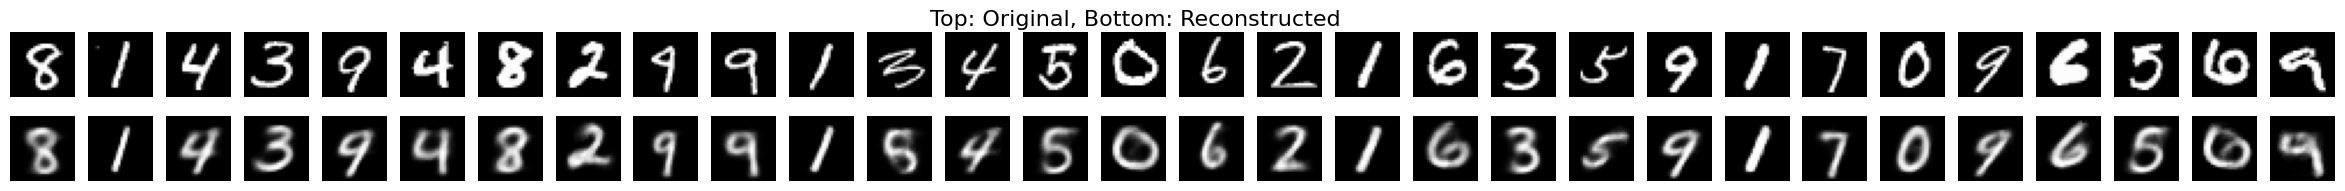

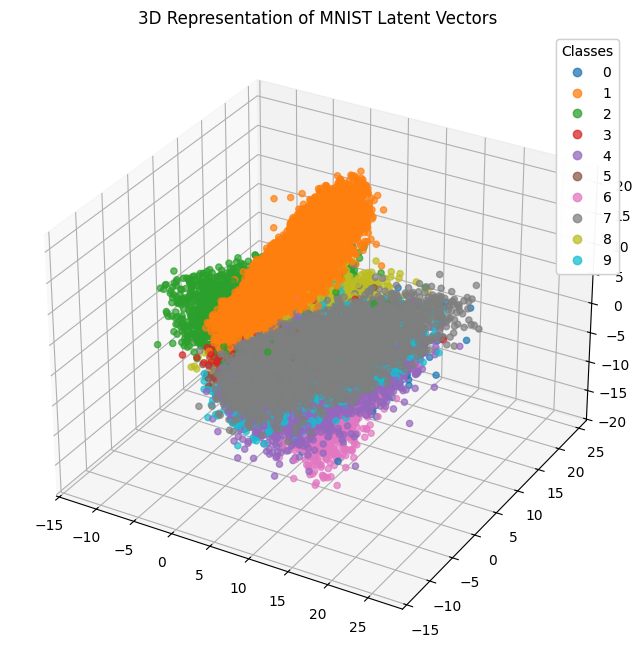

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Autoencoderの定義
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # エンコーダ部分
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 3)  # 3次元の潜在空間
        )
        # デコーダ部分
        self.decoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # 画像のピクセル値は0〜1にスケールされているのでSigmoidを使う
        )

    def forward(self, x):
        z = self.encoder(x)  # エンコーダで潜在空間へ圧縮
        x_reconstructed = self.decoder(z)  # デコーダで再構築
        return z, x_reconstructed

# データセットの準備
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST('./MNIST_data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# モデル、損失関数、最適化手法の定義
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# モデルの学習
epochs = 10
for epoch in range(epochs):
    for data, _ in train_loader:
        optimizer.zero_grad()
        z, output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 学習後の30サンプルの再構築結果を表示
test_samples = next(iter(train_loader))[0][:30]
with torch.no_grad():
    _, reconstructed = model(test_samples)

fig, axs = plt.subplots(2, 30, figsize=(30, 2))
for i in range(30):
    # オリジナルの画像
    axs[0, i].imshow(test_samples[i].view(28, 28).numpy(), cmap='gray')
    axs[0, i].axis('off')
    # 再構築された画像
    axs[1, i].imshow(reconstructed[i].view(28, 28).numpy(), cmap='gray')
    axs[1, i].axis('off')
plt.suptitle('Top: Original, Bottom: Reconstructed', fontsize=16)
plt.show()

# 全データの表現ベクトルを3次元空間上にプロット
all_data = train_dataset.data.view(-1, 28 * 28).float() / 255.0  # 正規化
all_labels = train_dataset.targets
with torch.no_grad():
    latent_vectors, _ = model(all_data)  # 全データをエンコーダに通して潜在ベクトルを取得

latent_vectors = latent_vectors.numpy()

# t-SNEで3次元にプロット
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(latent_vectors[:, 0], latent_vectors[:, 1], latent_vectors[:, 2], c=all_labels, cmap='tab10', alpha=0.7)
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)
plt.title('3D Representation of MNIST Latent Vectors')
plt.show()

